<a href="https://colab.research.google.com/github/alunfes/GoogleColabProjects/blob/main/DQN_Trading_One_Trade_Reward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2024-01-08 12:11:26--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 172.64.150.145, 104.18.37.111, 2606:4700:4400::ac40:9691, ...
Connecting to sourceforge.net (sourceforge.net)|172.64.150.145|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2024-01-08 12:11:26--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2024-01-08 12:11:26--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, aw

In [3]:
import pandas as pd
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time
import datetime
import talib as ta
from collections import deque, namedtuple
from numba import jit, njit

In [4]:
################################################################################
########################## Config ####################################
################################################################################
ohlc_directory = '/content/drive/My Drive/MarketData/ohlc'
model_directory = '/content/drive/My Drive/Model/'

In [5]:
################################################################################
########################## MarketData ####################################
################################################################################
class MarketData:
    @classmethod
    def initialize(cls, terms:list):
        cls.terms = terms
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.dt = []
        cls.ma_kairi = {} #term:ma_kairi
        cls.rsi = {} # 0 - 1.0
        cls.adx = {} #0.0 - 0.6
        cls.cci = {} #-1.0 - 1.0
        cls.cmo = {} #-1.0 - 1.0
        cls.dx = {} #0.0 - 1.0
        cls.minus_di = {} #0.0 - 1.0
        cls.plus_di = {} #0.0 - 1.0
        cls.rocr = {} #0.8 - 1.1
        cls.correl = {} #-1.0 - 1.0
        cls.__read_data()
        cls.__calc_all_index()


    @classmethod
    def __read_data(cls):
        df = pd.read_csv(ohlc_directory+'/bybit-USDT-BTC.csv')
        cls.open = df['open'].tolist()
        cls.high = df['high'].tolist()
        cls.low = df['low'].tolist()
        cls.close = np.array(df['close'].tolist())
        cls.dt = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.adx[term] = cls.__calc_adx(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.minus_di[term] = cls.__calc_minus_di(term)
            cls.plus_di[term] = cls.__calc_plus_di(term)
            cls.rocr[term] = cls.__calc_rocr(term)
            cls.correl[term] = cls.__calc_correl(term)

    @classmethod
    def __calc_ma_kairi(cls, term):
        '''
        ma = pd.Series(cls.close).rolling(window=term).mean()  # 移動平均を計算
        ma_kairi = ((pd.Series(cls.close) - ma) / ma) * 100  # 乖離率を計算
        ma_kairi[:term] = np.nan  # 最初のterm要素をnanに設定
        return ma_kairi.tolist()
        '''
        # Calculate moving average using talib's SMA (Simple Moving Average) function
        ma = ta.SMA(np.array(cls.close, dtype='f8'), timeperiod=term)
        # Calculate the deviation (kairi) from the moving average
        ma_kairi = ((np.array(cls.close, dtype='f8') - ma) / ma) * 100
        return ma_kairi

    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_adx(cls, term):
        return ta.ADX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_cci(cls, term):
        return ta.CCI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 1500

    @classmethod
    def __calc_cmo(cls, term):
        return ta.CMO(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_dx(cls, term):
        return ta.DX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_minus_di(cls, term):
        return ta.MINUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_plus_di(cls, term):
        return ta.PLUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_rocr(cls, term):
        return ta.ROCR100(np.array(cls.close, dtype='f8'), timeperiod=term) / 100.0

    @classmethod
    def __calc_correl(cls, term):
        return ta.CORREL(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), timeperiod=term)



    @classmethod
    def generate_state(cls, current_index):
        state = []
        for term in cls.terms:
            # 各指標の値をリストに追加
            term_state = [
                cls.ma_kairi[term][current_index],
                cls.rsi[term][current_index],
                cls.adx[term][current_index],
                cls.cci[term][current_index],
                cls.cmo[term][current_index],
                cls.dx[term][current_index],
                cls.minus_di[term][current_index],
                cls.plus_di[term][current_index],
                cls.rocr[term][current_index],
                cls.correl[term][current_index],
            ]
            state.append(term_state)
        return state


MarketData.initialize([5, 15, 60, 120, 240, 720])

Step 0:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 1:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 2:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 3:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00, Position: Side 0, Position Amount: 0.00, Total Asset: 10000.00, Free Cash: 10000.00, Total fee: 0.00, Lot 0.00, Unrealized PnL: 0.00, Total Realized PnL: 0.00
Step 4:Action type: 0, Asset Ratio: 1.00, Num Trades: 0, Win Rate: 0.00,

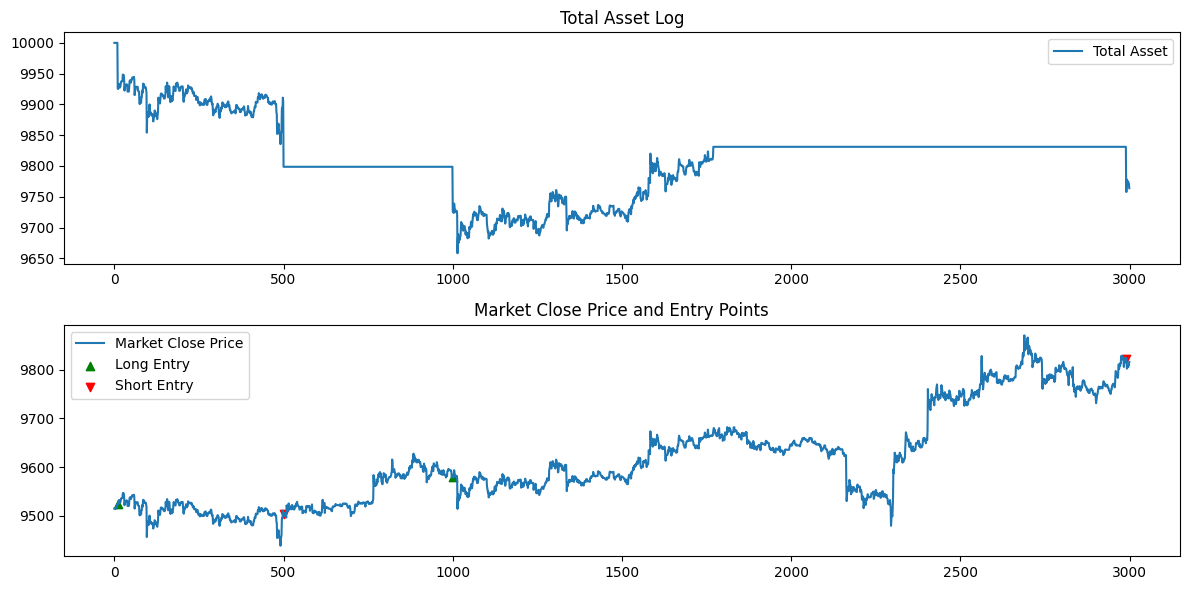

In [6]:
################################################################################
########################## Trading Env ####################################
'''
*まずはFull Market Orderのみで試す。


前提:
Order Cash Ratio: 1.0
・新規エントリ / 追加エントリー: free cashに対する割合
・反対売買:free cash + position sizeに対する割合
・１トレード終わった時点でアクションごとの報酬を決める。



Actions:
0: no action
1: Full Long Market Order
2: Full Short Market Order


記録：
・Entry時のindexと価格
・Exit時のindexと価格

報酬計算：
entry: 1 or -1, 基準期間内のif plus(best change ratio - max drowdown - fee - spread)
exit: 1 or -1, 基準期間内のif plus(actual exit point - median change ratio - fee - spread)
hold: 0.1 if favorable price change -0.1 if unfavorable price change
invalid action: -0.1


＊任意期間を過ぎても売却しなかった場合は、基準日に強制売却したとして処理する。


Process:
・position side == 0から1 or -1になる新規エントリーと検知、エントリーindを記録
・exitまでの追加購入、holdの記録をとる
・exitを検知して報酬を計算する。
・報酬とone trade completion flagを返す


Position sizeとtotal asset計算の修正：
position size = position price * position lot
total asset = position size + free cash + unrealized pnl

exit時の計算がおかしくassetのjump upが起こっている。


'''
################################################################################
class TradingEnvOneTradeRewarding:
    def __init__(self, display_flg, start_ind, end_ind, state_length, is_done_pnl_ratio=-0.2, is_done_trade_ratio=6.9e-04, spread_ratio=0.0005, maker_fee_ratio=0.001,
                 taker_fee_ratio=0.007, effective_digits=4, max_trade_cycle_period = 1440, reward_kijun_pnl_ratio = 0.01):
        self.display_flg = display_flg
        self.start_ind = start_ind
        self.end_ind = end_ind
        self.state_length = state_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.initial_asset = 10000
        self.max_orders = 50
        self.spread_ratio = spread_ratio
        self.maker_fee_ratio = maker_fee_ratio
        self.taker_fee_ratio = taker_fee_ratio
        self.effective_digits = effective_digits
        self.max_trade_cycle_period = max_trade_cycle_period
        self.reward_kijun_pnl_ratio = reward_kijun_pnl_ratio
        self.reset()

    def __init_position(self):
        self.position_side = 0
        self.position_price = 0
        self.position_lot = 0
        self.position_entry_ind = 0


    def __get_position_size(self):
        return self.position_price * self.position_lot


    def __init_order(self):
        self.order_side = []
        self.order_price = []
        self.order_cash_ratio = [] #
        self.order_placed_num_steps = []
        self.order_price_close_ratio = 0  # Order price / current price ratio
        self.order_amount_close_ratio = 0  # order amount / current price ratio

    def __init_performance(self):
        self.total_asset = self.initial_asset
        self.total_asset_change_ratio = 0
        self.free_cash = self.initial_asset
        self.total_fee = 0
        self.total_pnl = 0
        self.total_realized_pnl = 0
        self.unrealized_pnl = 0
        self.unrealized_pnl_ratio = 0
        self.position_amount_total_asset_ratio = 0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.average_holding_period = 0
        self.total_asset_when_last_entry = 0

    def __init_log(self):
        self.total_asset_log = [self.initial_asset] * self.state_length
        self.free_cash_log = deque([self.initial_asset] * self.state_length, maxlen=self.state_length)
        self.total_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.total_realized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.unrealized_pnl_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_side_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_price_log = deque([0] * self.state_length, maxlen=self.state_length)
        self.position_amount_total_asset_ratio_log = deque([0] * self.state_length, maxlen=self.state_length)

    def __init_trade_log(self):
        self.entry_side = 0
        self.entry_ind = -1
        self.entry_price = -1
        self.entry_fee_ratio = 0
        self.exit_ind = -1
        self.exit_price = -1
        self.exit_fee_ratio = 0
        self.invalid_action_ind = []

    def __take_entry_trade_log(self, side, ind, price, fee_ratio):
        self.entry_side = side
        self.entry_ind = ind
        self.entry_price = price
        self.entry_fee_ratio = fee_ratio

    def __take_exit_trade_log(self, ind, price, fee_ratio):
        self.exit_ind = ind
        self.exit_price = price
        self.exit_fee_ratio = fee_ratio


    def reset(self):
        self.num_steps = 0
        self.current_action_ind = -1
        self.is_trade_done = 0 #1:done
        self.__init_position()
        self.__init_order()
        self.__init_performance()
        self.__init_log()
        self.__init_trade_log()
        return self.__generate_state()



    def __check_is_done(self):
        if self.is_done_pnl_ratio > (self.total_asset - self.initial_asset) / self.initial_asset:
            if self.display_flg:
                print('Env is done due to asset change ratio criteria!')
                print('total asset=',self.total_asset, ', asset ratio=', (self.total_asset - self.initial_asset) / self.initial_asset)
            return True
        elif self.is_done_trade_ratio > (self.num_trade+1) / (self.num_steps+1):
            if self.display_flg:
                print('Env is done due to num trade per step criteria!')
                print('num trade=', self.num_trade, ', steps=', self.num_steps)
            return True
        else:
            return False


    def __calc_unrealized_pnl(self):
        unrealized_pnl = self.position_side * (MarketData.close[self.start_ind + self.num_steps] - self.position_price) * self.position_lot
        return unrealized_pnl


    def __update_performance(self):
        self.unrealized_pnl = self.__calc_unrealized_pnl()
        self.unrealized_pnl_ratio = 0 if self.unrealized_pnl == 0 else self.unrealized_pnl / self.total_asset_when_last_entry
        self.win_rate = 0 if self.num_trade == 0 else self.num_win / self.num_trade
        self.position_amount_total_asset_ratio = (self.position_lot * self.position_price) / self.total_asset
        self.total_asset = self.__calc_total_asset()
        self.total_asset_change_ratio = (self.total_asset - self.initial_asset) / self.initial_asset

    def __update_order_index(self):
        current_market_price = MarketData.close[self.start_ind + self.num_steps]
        self.order_price_close_ratio = np.array(self.order_price) / current_market_price
        self.order_amount_close_ratio = np.array(self.order_lot) * current_market_price / self.total_asset

    def __take_log(self):
        self.total_asset_log.append(self.total_asset)
        self.free_cash_log.append(self.free_cash)
        self.total_pnl_log.append(self.total_pnl)
        self.total_realized_pnl_log.append(self.total_realized_pnl)
        self.unrealized_pnl_log.append(self.unrealized_pnl)
        self.unrealized_pnl_ratio_log.append(self.unrealized_pnl_ratio)
        self.position_side_log.append(self.position_side)
        self.position_price_log.append(self.position_price)
        self.position_amount_total_asset_ratio_log.append(self.position_amount_total_asset_ratio)

    def __generate_state(self):
        state = []
        state.append(torch.tensor(np.array(list(self.position_side_log)[-self.state_length:]), dtype=torch.float32).tolist())
        state.append(torch.tensor(np.array(list(self.unrealized_pnl_ratio_log)[-self.state_length:]), dtype=torch.float32).tolist())
        return state



    def step(self, action_ind, action_ratio):
        if self.__check_max_trade_cycle_period_exceeding() == False:
            self.__take_action(action_ind)
        self.__check_execution()
        self.__update_performance()
        is_done = self.__check_is_done()
        self.__take_log()
        self.num_steps += 1
        return is_done, self.__generate_state(), self.__calc_reward()


    def __check_max_trade_cycle_period_exceeding(self):
        if self.is_trade_done == 0 and self.position_side != 0 and self.start_ind + self.num_steps - self.entry_ind >= self.max_trade_cycle_period:
            action_ind = 1 if self.position_side == -1 else 2
            self.__take_action(action_ind)
            print('Exceeded max_trade_cycle_period!')
            return True
        else:
            return False



    def __take_action(self, action_ind):
        if action_ind == 0:
            pass
        elif (action_ind == 1 and self.position_side == 1) or (action_ind == 2 and self.position_side == -1): #invalid action
            self.invalid_action_ind.append(self.num_steps + self.start_ind)
        else:
            if self.position_side == 0: #new entry
                otype = 'market'
                oside = 1 if action_ind == 1 else -1
                oprice = self.__calc_best_bid_ask(oside)  # limit order price is fixed at best bid / ask
                ocash_ratio = 1.0
                self.is_trade_done = 0
                self.__entry_order(otype, oside, oprice, ocash_ratio)
                self.__take_entry_trade_log(oside, self.start_ind + self.num_steps, oprice, self.taker_fee_ratio)
            else: #full exit, calc reward for 1 trade
                otype = 'market'
                oside = 1 if action_ind == 1 else -1
                oprice = self.__calc_best_bid_ask(oside)  # limit order price is fixed at best bid / ask
                ocash_ratio = 1.0
                self.is_trade_done = 1
                self.__take_exit_trade_log(self.start_ind + self.num_steps, oprice, self.taker_fee_ratio)
                self.__entry_order(otype, oside, oprice, ocash_ratio)




    def __calc_best_bid_ask(self, oside):
        return MarketData.close[self.start_ind + self.num_steps] * (1.0 + self.spread_ratio) if oside == 1 else MarketData.close[self.start_ind + self.num_steps] * (1.0 - self.spread_ratio)


    #call this func only when exit order was executed
    def __calc_reward(self):
        '''
        entry: 1 or -1, 基準期間内のif plus(best change ratio + max drowdown - fee - spread)
        exit: 1 or -1, 基準期間内のif plus(actual exit point - median change ratio - fee - spread)
        hold: 0.01 if favorable price change -0.01 if unfavorable price change
        invalid action: -0.1
        '''
        if self.is_trade_done > 0:
            rewards = [0] * (self.entry_ind - self.start_ind)
            #entry reward
            if self.entry_side == 1:
                best_change_ratio = (max(MarketData.close[self.entry_ind : self.entry_ind + self.max_trade_cycle_period]) - self.entry_price) / self.entry_price
                max_drowdown = (min(MarketData.close[self.entry_ind : self.entry_ind + self.max_trade_cycle_period]) - self.entry_price) / self.entry_price
            else:
                best_change_ratio = (self.entry_price - min(MarketData.close[self.entry_ind : self.entry_ind + self.max_trade_cycle_period])) / self.entry_price
                max_drowdown = (self.entry_price - max(MarketData.close[self.entry_ind : self.entry_ind + self.max_trade_cycle_period])) / self.entry_price
            entry_expected_pnl_ratio = best_change_ratio + max_drowdown - self.entry_fee_ratio
            if entry_expected_pnl_ratio >= self.reward_kijun_pnl_ratio:
                rewards.append(1)
            elif entry_expected_pnl_ratio < self.reward_kijun_pnl_ratio and entry_expected_pnl_ratio >= -self.reward_kijun_pnl_ratio:
                rewards.append(0)
            else:
                rewards.append(-1)
            #print('best_change_ratio=', best_change_ratio, ', max_drowdown=',max_drowdown, ', entry_expected_pnl_ratio=', entry_expected_pnl_ratio, ', entry_price=', self.entry_price, ', position_side=', self.position_side)
            #holding period rewards
            for i in range(self.exit_ind - self.entry_ind - 1):
                if self.entry_side == 1:
                    hold_reward = 0.01 if MarketData.close[self.entry_ind + i + 1] - MarketData.close[self.entry_ind + i] >= 0 else -0.01
                else:
                    hold_reward = 0.01 if MarketData.close[self.entry_ind + i + 1] - MarketData.close[self.entry_ind + i] <= 0 else -0.01
                if (i+1 + self.entry_ind) in self.invalid_action_ind:
                    self.invalid_action_ind.remove(i+1 + self.entry_ind)
                    invalid_action_reward = -0.1
                else:
                    invalid_action_reward = 0
                rewards.append(hold_reward + invalid_action_reward)
            #exit reward
            if self.entry_side == 1:
                median_change_ratio = (np.median(np.array(MarketData.close[self.entry_ind : self.entry_ind + self.max_trade_cycle_period])) - self.entry_price) / self.entry_price
                actual_exit_ratio = (self.exit_price - self.entry_price) / self.entry_price
            else:
                median_change_ratio = (self.entry_price - np.median(np.array(MarketData.close[self.entry_ind : self.entry_ind + self.max_trade_cycle_period]))) / self.entry_price
                actual_exit_ratio = (self.entry_price - self.exit_price) / self.entry_price
            exit_expected_pnl_ratio = actual_exit_ratio - abs(median_change_ratio) - self.exit_fee_ratio
            if exit_expected_pnl_ratio >= self.reward_kijun_pnl_ratio:
                rewards.append(1)
            elif exit_expected_pnl_ratio < self.reward_kijun_pnl_ratio and exit_expected_pnl_ratio >= -self.reward_kijun_pnl_ratio:
                rewards.append(0)
            else:
                rewards.append(-1)
            self.__init_trade_log()
            self.is_trade_done = 0
            return rewards
        else:
            return []




    def __entry_order(self, otype, oside, oprice, ocash_ratio):
        if ocash_ratio > 1.0:
            if self.display_flg:
                print('TradingEnv: new order refused as cash ratio exceeded 1.0!')
            return False
        if self.position_side == 0 or self.position_side == oside:
            if self.free_cash <= 0.01:
                if self.display_flg:
                    print('TradingEnv.entry_order: Insufficient free cash!', ', ocash_ratio=', ocash_ratio, ', price=', oprice, ', free_cash=', self.free_cash)
        if otype == 'market':
            exec_price = self.__calc_best_bid_ask(oside)
            self.__execute_order(otype, oside, exec_price, ocash_ratio)
        else:
            self.__add_limit_order(oside, oprice, ocash_ratio)



    def __add_limit_order(self, oside, oprice, ocash_ratio):
        if len(self.order_side) < self.max_orders:
            self.order_side.append(oside)
            self.order_price.append(oprice)
            self.order_cash_ratio.append(ocash_ratio)
            self.order_placed_num_steps.append(self.num_steps)
        else:
            if self.display_flg:
                print('TradingEnv: new order refused as it exceeds max order num!')


    def __check_execution(self):
        for oind in reversed(range(len(self.order_side))):
            if self.num_steps > self.order_placed_num_steps[oind]: #発注したstepより後のohlcデータで約定確認
                order_executed = False  # 約定フラグ
                if self.order_side[oind] == 1:  # 買い注文
                    if MarketData.low[self.start_ind + self.num_steps] < self.order_price[oind]:
                        order_executed = True
                        self.__execute_order('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
                elif self.order_side[oind] == -1:  # 売り注文
                    if MarketData.high[self.start_ind + self.num_steps] > self.order_price[oind]:
                        order_executed = True
                        self.__execute_order('limit', self.order_side[oind], self.order_price[oind], self.order_cash_ratio[oind])
                else:
                    print('TradingEnv.__check_execution: Invalid order side !', self.order_side[oind])
                if order_executed:
                    del self.order_side[oind]
                    del self.order_price[oind]
                    del self.order_cash_ratio[oind]
                    del self.order_placed_num_steps[oind]


    def __calc_realized_pnl(self, exec_price, exec_lot):
        return self.position_side * (exec_price - self.position_price) * exec_lot


    def __calc_fee(self, otype, exec_price, exec_lot):
        fee = self.maker_fee_ratio * exec_price * exec_lot if otype == 'limit' else self.taker_fee_ratio * exec_price * exec_lot
        self.total_fee += fee
        return fee


    def __check_win_lose(self):
        if self.__calc_total_asset() > self.total_asset_when_last_entry:
            self.num_win += 1


    def __calc_total_asset(self):
        return self.__get_position_size() + self.free_cash + self.unrealized_pnl


    def __exit_all(self, otype, exec_price):
        fee = self.__calc_fee(otype, exec_price, self.position_lot)
        realized_pnl = self.__calc_realized_pnl(exec_price, self.position_lot)
        self.free_cash += round((self.position_lot * exec_price) - fee + realized_pnl, self.effective_digits)
        self.total_realized_pnl += realized_pnl
        self.num_trade += 1
        self.unrealized_pnl = 0
        self.__init_position()
        self.__check_win_lose()
        self.total_asset_when_last_entry = 0


    def __check_free_cash_amount(self, free_cash):
        if free_cash < 0:
            print('TradingEnv.check_free_cash_amount: Free cash amount should not be negative!', ', free cash=', free_cash)
            return False
        return True

    def __truncate_number(self, number, decimals=0):
        factor = 10 ** decimals
        return int(number * factor) / factor



    def __execute_order(self, otype, exec_side, exec_price, ocash_ratio):
        if self.position_side == 0 or self.position_side == exec_side: #new or additional execution
            tmp_amount = ocash_ratio * self.free_cash
            tmp_lot = tmp_amount / exec_price
            tmp_fee = self.__calc_fee(otype, exec_price, tmp_lot)
            lot = self.__truncate_number( (tmp_amount - tmp_fee) / exec_price, self.effective_digits)
            fee = self.__calc_fee(otype, exec_price, lot)
            self.free_cash -= round(fee + lot * exec_price, self.effective_digits)
            if self.__check_free_cash_amount(self.free_cash) == False:
                print('tmp_amount=',tmp_amount, ', tmp_lot=',tmp_lot, ', fee=',fee, ', lot=',lot, ', exec_price=',exec_price)
            self.position_price = (self.position_price * self.position_lot + exec_price * lot) / (self.position_lot + lot)
            self.position_lot = self.position_lot + lot
            if self.position_side == 0:
                self.position_entry_ind = self.start_ind + self.num_steps
                self.position_side = exec_side
                self.total_asset_when_last_entry = self.__calc_total_asset()
        elif self.position_side != exec_side:# exit order
            if self.free_cash / self.__get_position_size() <= 0.01 and ocash_ratio >= 0.99: #free cashがposition amountの1%以下でocash_ratioが0.99以上の場合はfull exitとして扱う。本当はfull exitというアクションを入れた方がいい？
                self.__exit_all(otype, exec_price)
            else:
                print('Debug-Partial exit should be not executed in the current condition!')
                tmp_amount = ocash_ratio * (self.free_cash + self.__get_position_size())
                tmp_lot = tmp_amount / exec_price
                fee = self.__calc_fee(otype, exec_price, tmp_lot)
                lot = self.__truncate_number( (tmp_amount - fee) / exec_price, self.effective_digits)
                if self.position_lot > lot: #partial exit
                    fee = self.__calc_fee(otype, exec_price, lot)
                    self.free_cash = round(self.free_cash - fee + lot * exec_price, self.effective_digits)
                    self.__check_free_cash_amount(self.free_cash)
                    self.position_lot -= lot
                    self.total_realized_pnl += self.__calc_realized_pnl(exec_price, lot)
                    print('Partial Exit should not be done in the current condition !')
                elif self.position_lot == lot: #full exit
                    self.__exit_all(otype, exec_price)
                else: #exit and opposit entry
                    print('exit and opposit entry should not be done in the current condition !')
                    #最初に全売却処理をする。
                    fee = self.__calc_fee(otype, exec_price, self.position_lot)
                    self.free_cash += round((self.position_lot * exec_price) - fee, self.effective_digits)
                    self.total_realized_pnl += self.__calc_realized_pnl(exec_price, self.position_lot)
                    pre_position_lot = self.position_lot
                    self.num_trade += 1
                    self.unrealized_pnl = 0
                    self.__init_position()
                    self.__check_win_lose()
                    self.total_asset_when_last_entry = 0
                    #一旦全売却完了後に残りを新規エントリーとして処理する。
                    self.position_entry_ind = self.start_ind + self.num_steps
                    self.position_side = exec_side
                    self.position_lot = lot - pre_position_lot
                    self.position_price = exec_price
                    self.free_cash -= round(self.position_lot * exec_price, self.effective_digits)
                    self.total_asset_when_last_entry = self.__calc_total_asset()
        else:
            print('TradingEnv.execute_order: Invalid Situation!')


'''
#Market Orderのテスト
# Initialize the trading environment
env = TradingEnvOneTradeRewarding(display_flg=True, start_ind=10000, end_ind=len(MarketData.close)-1, state_length=5)
# Simulation parameters
total_steps = 1000
order_probability = 0.005
long_entries, short_entries = [], []  # To track entry points for plotting
# Execute actions at each step
for step in range(total_steps):
    action_type = 0
    if random.random() < order_probability:
        action_type = random.choice([1, 2])  # 1: Long Market Order, 2: Short Market Order
    action_ratio = 1.0
    #action_ratio = random.uniform(0.1, 1.0)
    is_done, ac_state, reward = env.step(action_type, action_ratio)
    # Record entry points
    if action_type == 1:
        long_entries.append(step)
    elif action_type == 2:
        short_entries.append(step)
    # Display information per step
    print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    if is_done:
        print("Environment is done!")
        break
'''


#1 trade rewardingのテスト
# Initialize the trading environment
max_trade_cycle_period = 770
env = TradingEnvOneTradeRewarding(display_flg=True, start_ind=100000, end_ind=len(MarketData.close)-1, state_length=1000, max_trade_cycle_period = max_trade_cycle_period)
# Simulation parameters
total_steps = 3000
long_entries, short_entries = [], []  # To track entry points for plotting
# Execute actions at each step

exit_step = 0
for step in range(total_steps):
    if step == 10:
        action_type = 1
    elif step == 500:
        action_type = 2
    elif step == 1000:
        action_type = 1
    elif step == total_steps-10:
        action_type = 2
        exit_step = step
    else:
        action_type = 0
    action_ratio = 1.0
    #action_ratio = random.uniform(0.1, 1.0)
    is_done, ac_state, reward = env.step(action_type, action_ratio)
    # Record entry points
    if action_type == 1:
        long_entries.append(step)
    elif action_type == 2:
        short_entries.append(step)
    # Display information per step
    if len(reward) == 0:
        print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    else:
        print('*****************************Reward Calculated*****************************')
        print(reward)
        print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
        print('len reward=', len(reward), ', exit step=', exit_step)
    if is_done:
        print("Environment is done!")
        break


'''
# Limit Orderのテスト
# Initialize the trading environment
env = TradingEnv(display_flg=True, start_ind=10000, end_ind=len(MarketData.close)-1, state_length=5)
# Simulation parameters
total_steps = 1000
order_probability = 0.005
long_entries, short_entries = [], []  # To track entry points for plotting
# Execute actions at each step
for step in range(total_steps):
    action_type = 0
    action_ratio = random.uniform(0.1, 1.0)  # 注文比率をランダムに決定
    #action_ratio = 1.0
    if random.random() < order_probability:
        action_type = random.choice([3, 4])
    is_done, ac_state, reward = env.step(action_type, action_ratio)
    # Record entry points
    if action_type == 3:
        long_entries.append(step)
    elif action_type == 4:
        short_entries.append(step)
    # Display information per step
    print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    if is_done:
        print("Environment is done!")
        break
'''

'''
# BidAsk Orderのテスト
# Initialize the trading environment
start_ind = 100000
is_done_trade_ratio = 0
env = TradingEnv(display_flg=True, start_ind=start_ind, end_ind=len(MarketData.close)-1, state_length=5, is_done_trade_ratio = is_done_trade_ratio)
# Simulation parameters
total_steps = 1000000
long_entries, short_entries = [], []  # To track entry points for plotting
# Execute actions at each step
for step in range(total_steps):
    action_type = 3 if step % 2 == 0 else 4
    action_ratio = 0.1
    oprice = MarketData.close[step + start_ind] * 1.015 if action_type == 4 else MarketData.close[step + start_ind] * 0.985
    if len(env.order_side) >= 20:
        is_done, ac_state, reward = env.step(6, 0, 0)
    else:
        is_done, ac_state, reward = env.step(action_type, action_ratio, oprice)
    # Record entry points
    if action_type == 3:
        long_entries.append(step)
    elif action_type == 4:
        short_entries.append(step)
    # Display information per step
    print(f"Step {step}:Action type: {action_type}, Asset Ratio: {env.total_asset/env.initial_asset:.2f}, Num Trades: {env.num_trade}, Win Rate: {env.win_rate:.2f}, Position: Side {env.position_side}, Position Amount: {env.position_price * env.position_lot:.2f}, Total Asset: {env.total_asset:.2f}, Free Cash: {env.free_cash:.2f}, Total fee: {env.total_fee:.2f}, Lot {env.position_lot:.2f}, Unrealized PnL: {env.unrealized_pnl:.2f}, Total Realized PnL: {env.total_realized_pnl:.2f}")
    if is_done:
        print("Environment is done!")
        break
'''


# Plotting
plt.figure(figsize=(12, 6))
# Plot total asset log
plt.subplot(2, 1, 1)
plt.plot(env.total_asset_log[env.state_length:], label='Total Asset')
plt.legend()
plt.title('Total Asset Log')
# Plot MarketData.close with long and short entries
valid_close_data = MarketData.close[env.start_ind:env.start_ind + len(env.total_asset_log[env.state_length:])]
plt.subplot(2, 1, 2)
plt.plot(valid_close_data, label='Market Close Price')
# long_entries と short_entries のクローズ価格を取得
long_close_prices = [MarketData.close[env.start_ind + i] for i in long_entries if env.start_ind + i < len(MarketData.close)]
short_close_prices = [MarketData.close[env.start_ind + i] for i in short_entries if env.start_ind + i < len(MarketData.close)]
# エントリポイントをプロット
plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
plt.legend()
plt.title('Market Close Price and Entry Points')
plt.tight_layout()
plt.show()


In [7]:
##########################################################################################
################################# Replay Memory #######################################
##########################################################################################
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        self. Transition = namedtuple('Transition', (
            'md_state',
            'md_next_state',
            'ac_state',
            'ac_next_state',
            'action',
            'reward',
            'is_done'))

    def push(self, *args):
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def get_len(self):
        return len(self.memory)


In [ ]:
################################################################################
######################## NN for MarketOrder only Strategy #############################
################################################################################
'''
Inputs:
・ma_kairi * terms
・Hist unrealized pnl ratio
・Hist position side

Outputs:
・0:No, 1:Long Market Order, 2:Short Market Order
'''
################################################################################
class DuelingDQN(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(DuelingDQN, self).__init__()
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.num_md_out1 = int(md_state_length * 0.5)
        self.num_ac_out1 = int(ac_state_length * 0.5)
        self.num_md_in2 = int(self.num_md_out1 * md_state_num)
        self.num_md_out2 = int(self.num_md_out1 * md_state_num * 0.5)
        self.num_ac_in2 = int(self.num_ac_out1 * ac_state_num)
        self.num_ac_out2 = int(self.num_ac_out1 * ac_state_num * 0.5)
        self.num_pre_final_out = int(0.5 * (self.num_md_out2 + self.num_ac_out2))
        # Layers
        self.md_linears1 = nn.ModuleList([nn.Linear(md_state_length, md_state_length) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(ac_state_length, ac_state_length) for _ in range(ac_state_num)])
        self.md_linears2 = nn.ModuleList([nn.Linear(md_state_length, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(ac_state_length, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_con_linears3 = nn.Linear(self.num_md_in2, self.num_md_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_in2, self.num_ac_out2)
        self.all_con_linears4 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_md_out2 + self.num_ac_out2)
        self.all_con_linears5 = nn.Linear(self.num_md_out2 + self.num_ac_out2, self.num_pre_final_out)
        # Value and Advantage layers
        self.value = nn.Linear(self.num_pre_final_out, 1)
        self.advantage = nn.Linear(self.num_pre_final_out, output_size)
        # Apply He initialization
        for i in range(md_state_num):
            nn.init.kaiming_uniform_(self.md_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears2[i].weight, nonlinearity='relu')
        for i in range(ac_state_num):
            nn.init.kaiming_uniform_(self.ac_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears2[i].weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears4.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears5.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.value.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.advantage.weight, nonlinearity='relu')


    def forward(self, md_state, ac_state):
        md_out_list = []
        for i in range(self.md_state_num):
            md = md_state[:, i, :]
            md_out = F.relu(self.md_linears1[i](md))
            md_out_list.append(md_out)
        md_out = torch.stack(md_out_list, dim=1)
        ac_out_list = []
        for i in range(self.ac_state_num):
            ac = ac_state[:, i, :]
            ac_out = F.relu(self.ac_linears1[i](ac))
            ac_out_list.append(ac_out)
        ac_out = torch.stack(ac_out_list, dim=1)
        # Second layer processing
        md_out_list = []
        for i in range(self.md_state_num):
            md = md_out[:, i, :]
            md_out_new = F.relu(self.md_linears2[i](md))
            md_out_list.append(md_out_new)
        md_out = torch.stack(md_out_list, dim=1)
        ac_out_list = []
        for i in range(self.ac_state_num):
            ac = ac_out[:, i, :]
            ac_out_new = F.relu(self.ac_linears2[i](ac))
            ac_out_list.append(ac_out_new)
        ac_out = torch.stack(ac_out_list, dim=1)
        # Concatenate and further processing
        md_out = torch.flatten(md_out, start_dim=1)
        ac_out = torch.flatten(ac_out, start_dim=1)
        md_out = F.relu(self.md_con_linears3(md_out))
        ac_out = F.relu(self.ac_con_linears3(ac_out))
        all_concat = torch.cat([md_out, ac_out], dim=1)
        all_concat = F.relu(self.all_con_linears4(all_concat))
        all_concat = F.relu(self.all_con_linears5(all_concat))
        # Value and Advantage calculation
        value = self.value(all_concat)
        advantages = self.advantage(all_concat)
        q_values = value + (advantages - advantages.mean())
        return q_values



In [8]:
class DuelingDQNLarge(nn.Module):
    def __init__(self, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        super(DuelingDQNLarge, self).__init__()
        #Size: linera layers
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.md_state_length = md_state_length
        self.ac_state_length = ac_state_length
        self.num_md_out0 = int(md_state_length * 3)
        self.num_ac_out0 = int(ac_state_length * 3)
        self.num_md_out1 = int(md_state_length * 2)
        self.num_ac_out1 = int(ac_state_length * 2)
        #Size: concat layers
        self.num_md_con_in = int(self.md_state_length * md_state_num)
        self.num_md_con_out = int(self.md_state_length * md_state_num)
        self.num_ac_con_in = int(self.ac_state_length * ac_state_num)
        self.num_ac_con_out = int(self.ac_state_length * ac_state_num)
        self.num_md_con_out2 = int(self.num_md_con_out * 0.5)
        self.num_ac_con_out2 = int(self.num_ac_con_out * 0.5)
        #Size: md + ac concat layers
        self.num_all_con_out = int(0.5 * (self.num_md_con_out2  + self.num_ac_con_out2))

        # Layers
        self.md_linears0 = nn.ModuleList([nn.Linear(self.md_state_length, self.num_md_out0) for _ in range(md_state_num)])
        self.ac_linears0 = nn.ModuleList([nn.Linear(self.ac_state_length, self.num_ac_out0) for _ in range(ac_state_num)])
        self.md_linears1 = nn.ModuleList([nn.Linear(self.num_md_out0, self.num_md_out0) for _ in range(md_state_num)])
        self.ac_linears1 = nn.ModuleList([nn.Linear(self.num_ac_out0, self.num_ac_out0) for _ in range(ac_state_num)])
        self.md_linears2 = nn.ModuleList([nn.Linear(self.num_md_out0, self.num_md_out0) for _ in range(md_state_num)])
        self.ac_linears2 = nn.ModuleList([nn.Linear(self.num_ac_out0, self.num_ac_out0) for _ in range(ac_state_num)])
        self.md_linears3 = nn.ModuleList([nn.Linear(self.num_md_out0, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears3 = nn.ModuleList([nn.Linear(self.num_ac_out0, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_linears4 = nn.ModuleList([nn.Linear(self.num_md_out1, self.num_md_out1) for _ in range(md_state_num)])
        self.ac_linears4 = nn.ModuleList([nn.Linear(self.num_ac_out1, self.num_ac_out1) for _ in range(ac_state_num)])
        self.md_linears5 = nn.ModuleList([nn.Linear(self.num_md_out1, self.md_state_length) for _ in range(md_state_num)])
        self.ac_linears5 = nn.ModuleList([nn.Linear(self.num_ac_out1, self.ac_state_length) for _ in range(ac_state_num)])
        #concat layers
        self.md_con_linears1 = nn.Linear(self.num_md_con_in, self.num_md_con_out)
        self.ac_con_linears1 = nn.Linear(self.num_ac_con_in, self.num_ac_con_out)
        self.md_con_linears2 = nn.Linear(self.num_md_con_in, self.num_md_con_out)
        self.ac_con_linears2 = nn.Linear(self.num_ac_con_in, self.num_ac_con_out)
        self.md_con_linears3 = nn.Linear(self.num_md_con_in, self.num_md_con_out2)
        self.ac_con_linears3 = nn.Linear(self.num_ac_con_in, self.num_ac_con_out2)
        #final concat layers
        self.all_con_linears1 = nn.Linear(self.num_md_con_out2 + self.num_ac_con_out2, self.num_md_con_out2 + self.num_ac_con_out2)
        self.all_con_linears2 = nn.Linear(self.num_md_con_out2 + self.num_ac_con_out2, self.num_md_con_out2 + self.num_ac_con_out2)
        self.all_con_linears3 = nn.Linear(self.num_md_con_out2 + self.num_ac_con_out2, self.num_all_con_out)
        self.all_con_linears4 = nn.Linear(self.num_all_con_out, self.num_all_con_out)
        # Value and Advantage layers
        self.value = nn.Linear(self.num_all_con_out, 1)
        self.advantage = nn.Linear(self.num_all_con_out, output_size)
        # Apply He initialization
        for i in range(md_state_num):
            nn.init.kaiming_uniform_(self.md_linears0[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears2[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears3[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears4[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.md_linears5[i].weight, nonlinearity='relu')
        for i in range(ac_state_num):
            nn.init.kaiming_uniform_(self.ac_linears0[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears1[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears2[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears3[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears4[i].weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.ac_linears5[i].weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.md_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.ac_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.all_con_linears4.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.value.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.advantage.weight, nonlinearity='relu')

    def forward(self, md_state, ac_state):
        #md, ac linear layer processing
        md_out_list, ac_out_list = [], []
        for i in range(self.md_state_num):
            md = md_state[:, i, :]
            md = F.relu(self.md_linears0[i](md))
            md = F.relu(self.md_linears1[i](md))
            md = F.relu(self.md_linears2[i](md))
            md = F.relu(self.md_linears3[i](md))
            md = F.relu(self.md_linears4[i](md))
            md = F.relu(self.md_linears5[i](md))
            md_out_list.append(md)
        md_out = torch.cat(md_out_list, dim=1)
        for i in range(self.ac_state_num):
            ac = ac_state[:, i, :]
            ac = F.relu(self.ac_linears0[i](ac))
            ac = F.relu(self.ac_linears1[i](ac))
            ac = F.relu(self.ac_linears2[i](ac))
            ac = F.relu(self.ac_linears3[i](ac))
            ac = F.relu(self.ac_linears4[i](ac))
            ac = F.relu(self.ac_linears5[i](ac))
            ac_out_list.append(ac)
        ac_out = torch.cat(ac_out_list, dim=1)
        # Concatenate and further processing
        md_out = torch.flatten(md_out, start_dim=1)
        ac_out = torch.flatten(ac_out, start_dim=1)
        md_out = F.relu(self.md_con_linears1(md_out))
        md_out = F.relu(self.md_con_linears2(md_out))
        md_out = F.relu(self.md_con_linears3(md_out))
        ac_out = F.relu(self.ac_con_linears1(ac_out))
        ac_out = F.relu(self.ac_con_linears2(ac_out))
        ac_out = F.relu(self.ac_con_linears3(ac_out))
        all_concat = torch.cat([md_out, ac_out], dim=1)
        all_concat = F.relu(self.all_con_linears1(all_concat))
        all_concat = F.relu(self.all_con_linears2(all_concat))
        all_concat = F.relu(self.all_con_linears3(all_concat))
        all_concat = F.relu(self.all_con_linears4(all_concat))
        # Value and Advantage calculation
        value = self.value(all_concat)
        advantages = self.advantage(all_concat)
        q_values = value + (advantages - advantages.mean())
        return q_values


In [ ]:
class Agent:
    def __init__(self, load_model, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size, learning_rate=1e-03, BUFFER_SIZE=500000, BATCH_SIZE=1024, UPDATE_EVERY=128,
                 GAMMA=0.98, TAU=0.005, sim_start_ind_scope=[10000, 300000], max_sim_length=1000000, is_done_pnl_ratio=-0.2, is_done_trade_ratio = 6.9e-04, max_trade_cycle_period = 1440):
        self.model_path = model_directory+'dqn_trading_model.pth'
        self.md_state_length = md_state_length
        self.md_state_num = md_state_num
        self.ac_state_length = ac_state_length
        self.ac_state_num = ac_state_num
        self.output_size = output_size
        # Rainbow DQNネットワーク（ローカルとターゲット）
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork_local = DuelingDQNLarge(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.qnetwork_target = DuelingDQNLarge(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        if load_model:
            if os.path.isfile(self.model_path):
                self.__load_model()
                print("Loaded model weights from:", self.model_path)
        self.UPDATE_EVERY = UPDATE_EVERY
        self.GAMMA = GAMMA
        self.TAU = TAU
        # Prioritized Experience Replayメモリ（容量100000）
        self.BATCH_SIZE = BATCH_SIZE
        self.sim_start_ind_scope = sim_start_ind_scope
        self.max_sim_length = max_sim_length
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_trade_ratio = is_done_trade_ratio
        self.max_trade_cycle_period = max_trade_cycle_period
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.num_get_reward = 0
        self.num_learned = 0


    def __load_model(self):
        checkpoint = torch.load(self.model_path, map_location=self.device)
        self.qnetwork_local.load_state_dict(checkpoint['model_state_dict'])
        self.qnetwork_target.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.qnetwork_local.train()
        self.qnetwork_target.train()
        self.qnetwork_local = self.qnetwork_local.to(self.device)
        self.qnetwork_target = self.qnetwork_target.to(self.device)
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.device)


    def __save_model(self, model, optimizer):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, self.model_path)


    def add_memory(self, md_state, md_next_state, ac_state, ac_next_state, action, reward, is_done):
        for i in range(len(md_state)):
            self.memory.push(md_state[i], md_next_state[i], ac_state[i], ac_next_state[i], action[i], reward[i], is_done[i])


    def act(self, md_state, ac_state, eps=0.):
        # Epsilon-greedyによる行動選択
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(md_state, ac_state)
        self.qnetwork_local.train()
        # Epsilon-greedyポリシー
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.output_size))

    def learn(self):
        # 学習間隔ごとに学習
        if (self.num_get_reward + 1) % self.UPDATE_EVERY == 0:
            # メモリからランダムな経験と学習
            if self.memory.get_len() > self.BATCH_SIZE:
                experiences = self.memory.sample(self.BATCH_SIZE)
                batch = self.memory.Transition(*zip(*experiences))
                md_next_state = torch.tensor(batch.md_next_state, dtype=torch.float32).to(self.device)
                md_state = torch.tensor(batch.md_state, dtype=torch.float32).to(self.device)
                ac_next_state = torch.tensor(batch.ac_next_state, dtype=torch.float32).to(self.device)
                ac_state = torch.tensor(batch.ac_state, dtype=torch.float32).to(self.device)
                is_done = torch.tensor(batch.is_done, dtype=torch.float32).unsqueeze(1).to(self.device)
                reward = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(self.device)
                action = torch.tensor(batch.action, dtype=torch.float32).to(self.device)
                Q_targets_next = self.qnetwork_target(md_next_state, ac_next_state).detach().max(1)[0].unsqueeze(1)
                Q_targets = reward + (self.GAMMA * Q_targets_next * (1 - is_done))
                # 予想されるQ値を取得
                action = action.long().unsqueeze(1)  # action を int64 型に変換し、次元を追加
                Q_expected = self.qnetwork_local(md_state, ac_state).gather(1, action)
                # 損失を計算し、バックプロパゲーション
                loss = F.mse_loss(Q_expected, Q_targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                # ターゲットネットワークを更新
                self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)
                self.num_learned += 1


    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def train(self, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        scores = []                        # 各エピソードのスコアを保存するリスト
        scores_window = deque(maxlen=100)  # 最後の100スコア
        time_log = deque(maxlen=100)
        num_trade_log = deque(maxlen=100)
        win_rate_log = deque(maxlen=100)
        asset_change_ratio_log = deque(maxlen=100)
        eps = eps_start                    # Epsilonの初期値
        for i_episode in range(1, n_episodes+1):
            start_time = time.time()  # エピソードの開始時刻
            random_sim_start = random.randint(self.sim_start_ind_scope[0], self.sim_start_ind_scope[1])
            env = TradingEnvOneTradeRewarding(False, start_ind=random_sim_start, end_ind=random_sim_start + self.max_sim_length, state_length=self.ac_state_length, is_done_pnl_ratio=self.is_done_pnl_ratio,
                       is_done_trade_ratio=self.is_done_trade_ratio, max_trade_cycle_period = self.max_trade_cycle_period)
            ac_state = env.reset()            # 環境をリセットして初期状態を取得
            score = 0
            is_done_log = []
            md_state_log = []
            md_next_state_log = []
            ac_state_log = []
            ac_next_state_log = []
            action_log = []
            for t in range(self.max_sim_length):
                md_state = MarketData.generate_state(random_sim_start + t)
                md_next_state = MarketData.generate_state(random_sim_start + t+1)
                action = self.act(torch.tensor(md_state, dtype=torch.float32).unsqueeze(0).to(self.device), torch.tensor(ac_state, dtype=torch.float32).unsqueeze(0).to(self.device), eps)
                is_done, ac_next_state, reward,  = env.step(action, 1.0)
                is_done_log.append(is_done)
                md_state_log.append(md_state)
                md_next_state_log.append(md_next_state)
                ac_state_log.append(ac_state)
                ac_next_state_log.append(ac_next_state)
                action_log.append(action)
                if len(reward) > 0:
                    self.num_get_reward += 1
                    self.add_memory(md_state_log, md_next_state_log, ac_state_log, ac_next_state_log, action_log, reward, is_done_log)
                    self.learn()
                ac_state = ac_next_state
                score += sum(reward)
                if is_done:
                    break
            scores_window.append(score)       # 最新のスコアを保存
            scores.append(score)              # スコアをリストに追加
            time_log.append(time.time() - start_time)
            num_trade_log.append(env.num_trade)
            win_rate_log.append(env.win_rate)
            asset_change_ratio_log.append(env.total_asset_change_ratio)
            eps = max(eps_end, eps_decay*eps) # Epsilonを減衰させる
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                self.__save_model(self.qnetwork_local, self.optimizer)
            if i_episode % 100 == 0:
                print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}\tNum Learned: {self.num_learned}\tLen Memory: {self.memory.get_len()}\tNum Steps: {env.num_steps}\tNum Trade: {np.mean(num_trade_log)}\tWin Rate: {np.mean(win_rate_log)}\tAsset Change Ratio: {np.mean(asset_change_ratio_log):.2f}\tDuration: {sum(time_log):.2f} sec')
        return scores



# 学習パラメータの設定
load_model = True
ac_state_length = 770
max_trade_cycle_period = 770
num_md_index = 10
md_state_length = num_md_index
max_sim_length = 1000000
is_done_pnl_ratio = -0.2
is_done_trade_ratio = 6.9e-05
n_episodes = 20000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
UPDATE_EVERY = 128

agent = Agent(load_model, md_state_length, md_state_num=len(MarketData.terms), ac_state_length=ac_state_length, ac_state_num=2, output_size=3, learning_rate=1e-03, BUFFER_SIZE=200000, BATCH_SIZE=4096, UPDATE_EVERY=UPDATE_EVERY,
                 GAMMA=0.98, TAU=0.005, sim_start_ind_scope=[10000, 300000], max_sim_length=max_sim_length, is_done_pnl_ratio=is_done_pnl_ratio, is_done_trade_ratio = is_done_trade_ratio,
              max_trade_cycle_period = max_trade_cycle_period)

# 学習の実行
scores = agent.train(n_episodes, eps_start, eps_end, eps_decay)

# 学習の進捗をグラフで表示
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Loaded model weights from: /content/drive/My Drive/Model/dqn_trading_model.pth
Episode 100	Average Score: -16.21	Num Learned: 11	Len Memory: 70375	Num Steps: 116	Num Trade: 14.92	Win Rate: 0.005713235294117647	Asset Change Ratio: -0.20	Duration: 476.30 sec
Episode 200	Average Score: -16.44	Num Learned: 23	Len Memory: 180016	Num Steps: 157	Num Trade: 14.87	Win Rate: 0.006551986584107327	Asset Change Ratio: -0.20	Duration: 614.13 sec
Episode 300	Average Score: -15.60	Num Learned: 34	Len Memory: 200000	Num Steps: 303	Num Trade: 14.89	Win Rate: 0.01038095238095238	Asset Change Ratio: -0.20	Duration: 738.54 sec
Episode 348	Average Score: -15.54

Step 0: Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Win Rate: 0.00, Position: Side 1, Position Amount: 9929.54, Total Asset: 9925.53, Free Cash: 0.96, Total fee: 139.51, Lot 1.04, Unrealized PnL: -4.96, Total Realized PnL: 0.00
Step 1: Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Win Rate: 0.00, Position: Side 1, Position Amount: 9929.54, Total Asset: 9925.53, Free Cash: 0.96, Total fee: 139.51, Lot 1.04, Unrealized PnL: -4.96, Total Realized PnL: 0.00
Step 2: Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Win Rate: 0.00, Position: Side 1, Position Amount: 9929.54, Total Asset: 9925.53, Free Cash: 0.96, Total fee: 139.51, Lot 1.04, Unrealized PnL: -4.96, Total Realized PnL: 0.00
Step 3: Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Win Rate: 0.00, Position: Side 1, Position Amount: 9929.54, Total Asset: 9925.53, Free Cash: 0.96, Total fee: 139.51, Lot 1.04, Unrealized PnL: -4.96, Total Realized PnL: 0.00
Step 4: Action type: 1, Asset Ratio: 0.99, Num Trades: 0, Win Ra

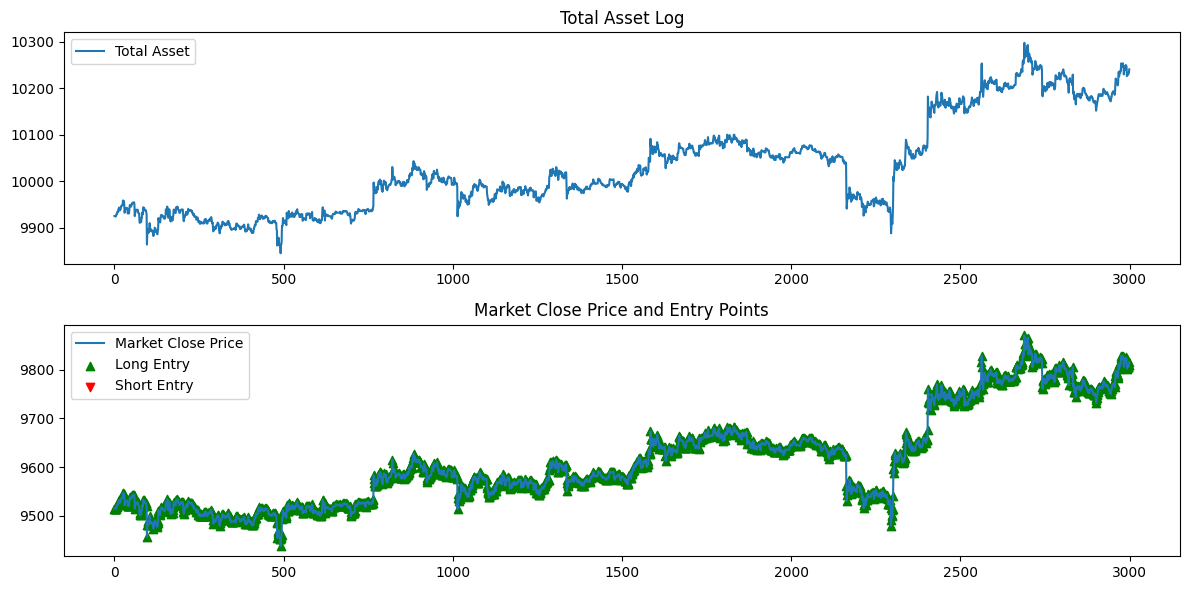

In [9]:
class LoadModelTradingSimulation:
    def __init__(self, start_index, simulation_length, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size):
        self.model_path = model_directory+'dqn_trading_model.pth'
        self.md_state_length =md_state_length
        self.md_state_num = md_state_num
        self.ac_state_num = ac_state_num
        self.ac_state_length = ac_state_length
        self.output_size = output_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DuelingDQNLarge(self.md_state_length, self.md_state_num, self.ac_state_length, self.ac_state_num, self.output_size).to(self.device)
        self.__load_model()
        self.start_index = start_index
        self.simulation_length = simulation_length
        self.current_index = start_index
        self.env = TradingEnvOneTradeRewarding(False, start_ind=self.start_index, end_ind=self.simulation_length + self.start_index, state_length=self.ac_state_length, is_done_pnl_ratio=-0.3,
                       is_done_trade_ratio=0, max_trade_cycle_period = len(MarketData.close))


    def __load_model(self):
        checkpoint = torch.load(self.model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        self.model = self.model.to(self.device)

    def __act(self, md_state, ac_state):
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(md_state, ac_state)
            return np.argmax(action_values.cpu().data.numpy())

    def run_simulation(self):
        ac_state = self.env.reset()  # 環境をリセット
        long_entries, short_entries = [], []  # To track entry points for plotting
        for step in range(self.simulation_length):
            md_state = MarketData.generate_state(self.current_index)
            md_state = torch.tensor(md_state, dtype=torch.float32).unsqueeze(0).to(self.device)
            ac_state = torch.tensor(ac_state, dtype=torch.float32).unsqueeze(0).to(self.device)
            action = self.__act(md_state, ac_state)
            if action == 1:
                long_entries.append(step)
            elif action == 2:
                short_entries.append(step)
            is_done, ac_next_state, reward, = self.env.step(action, 1.0)
            #print(f"Step {step}:Action type: {action}, Asset Ratio: {self.env.total_asset/self.env.initial_asset:.2f}, Num Trades: {self.env.num_trade}, Win Rate: {self.env.win_rate:.2f}, Position: Side {self.env.position_side}, Position Amount: {self.env.position_price * env.position_lot:.2f}, Total Asset: {self.env.total_asset:.2f}, Free Cash: {self.env.free_cash:.2f}, Total fee: {self.env.total_fee:.2f}, Lot {self.env.position_lot:.2f}, Unrealized PnL: {self.env.unrealized_pnl:.2f}, Total Realized PnL: {self.env.total_realized_pnl:.2f}")
            print(f"Step {step}: Action type: {action}, "
                f"Asset Ratio: {self.env.total_asset/self.env.initial_asset:.2f}, "
                f"Num Trades: {self.env.num_trade}, "
                f"Win Rate: {self.env.win_rate:.2f}, "
                f"Position: Side {self.env.position_side}, "
                f"Position Amount: {self.env.position_price * self.env.position_lot:.2f}, "
                f"Total Asset: {self.env.total_asset:.2f}, "
                f"Free Cash: {self.env.free_cash:.2f}, "
                f"Total fee: {self.env.total_fee:.2f}, "
                f"Lot {self.env.position_lot:.2f}, "
                f"Unrealized PnL: {self.env.unrealized_pnl:.2f}, "
                f"Total Realized PnL: {self.env.total_realized_pnl:.2f}")

            ac_state = ac_next_state
            self.current_index += 1
            if is_done:
                print('Is done criteria is reached!')
        self.display_step_info(long_entries, short_entries)


    def display_step_info(self, long_entries, short_entries):
        # Plotting
        plt.figure(figsize=(12, 6))
        # Plot total asset log
        plt.subplot(2, 1, 1)
        plt.plot(self.env.total_asset_log[self.env.state_length:], label='Total Asset')
        plt.legend()
        plt.title('Total Asset Log')
        # Plot MarketData.close with long and short entries
        valid_close_data = MarketData.close[self.env.start_ind:self.env.start_ind + len(self.env.total_asset_log[self.env.state_length:])]
        plt.subplot(2, 1, 2)
        plt.plot(valid_close_data, label='Market Close Price')
        # long_entries と short_entries のクローズ価格を取得
        long_close_prices = [MarketData.close[self.env.start_ind + i] for i in long_entries if self.env.start_ind + i < len(MarketData.close)]
        short_close_prices = [MarketData.close[self.env.start_ind + i] for i in short_entries if self.env.start_ind + i < len(MarketData.close)]
        # エントリポイントをプロット
        plt.scatter(long_entries, long_close_prices, color='green', marker='^', label='Long Entry')
        plt.scatter(short_entries, short_close_prices, color='red', marker='v', label='Short Entry')
        plt.legend()
        plt.title('Market Close Price and Entry Points')
        plt.tight_layout()
        plt.show()


# シミュレーションの設定
start_index = 100000  # 任意の開始位置
simulation_length = 3000  # シミュレーションの長さ

ac_state_num = 2
ac_state_length = 770
max_trade_cycle_period = 770
num_md_index = 10
md_state_length = num_md_index
md_state_num=len(MarketData.terms)
output_size = 3

# シミュレーションの実行
simulation = LoadModelTradingSimulation(start_index, simulation_length, md_state_length, md_state_num, ac_state_length, ac_state_num, output_size)
simulation.run_simulation()
